# Spectral Vertex Nomination

This demo shows how to use the Spectral Vertex Nomination (SVN) class. We will use SVN to nominate vertices in a Stochastic Block Model (SBM)

In [1]:
# imports
import numpy as np
from graspologic.nominate import SpectralVertexNomination
from graspologic.simulations import sbm
from graspologic.plot import heatmap
from matplotlib import pyplot as plt

%matplotlib inline

## What is Spectral Vertex Nomination?

Given a graph $G=(V,E)$ and a subset of $V$ called $S$ (the "seed"), Single Graph Vertex Nomination is the problem of ranking all $V$ ordered by degree of relation to members of $S$.
Spectral Vertex Nomination (SVN) solves the Vertex Nomination problem by embedding a graph's adjacency matrix into a low dimensional euclidean space, then using distance based methods to establish relationship between vertices. (See embedding tutorials)

SVN has the advantage of being extremely efficient on very large graphs, and requires very little prior knowledge of a graph's properties or structure. However, it does somewhat conflate the notion of community membership with vertex similarity.
This might not be appropriate for all vertex nomination use cases. Synthetic SBM data, with inherently defined communities, is therefore a good setting for demonstrating SVN.

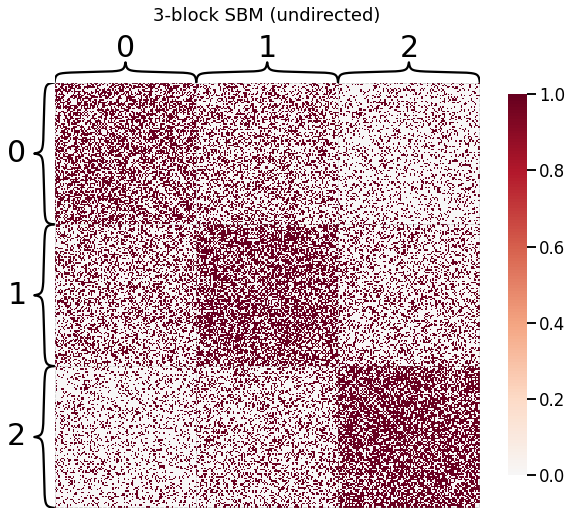

In [4]:
# construct graph from sbm
n_verts = 100
p = np.array([[0.5, 0.35, 0.2],
              [0.35, 0.6, 0.3],
              [0.2, 0.3, 0.65]])
labels = np.array([0] * n_verts + [1] * n_verts + [2] * n_verts)
adj = np.array(sbm(3 * [n_verts], p), dtype=np.int)
fig = heatmap(adj, title='3-block SBM (undirected)', inner_hier_labels=labels)

There are two cases of single graph vertex nomination. In the unattributed case, the seed $S$ is simply a list of any number of vertices in the graph $G$. For each seed vertex $s \in S$, SVN will return a list of the other vertices in order of distance to $s$.
Any distance metric supported by sklearn's `NearestNeighbors` can be used, euclidean is default and is generally sufficient.
Here, we select a seed of 5 random vertices.

In [5]:
# instantiate a default SVN
svn = SpectralVertexNomination(n_neighbors=5)
# fit to the adjacency matrix
svn.fit(X=adj)

SpectralVertexNomination(n_neighbors=5)

The predict method does not require any arguments since this is single graph VN. It generates the nomination list, and returns a tuple of the nomination list itself and the associated distance matrix. The top 5 vertices for each seed are plotted along the first two dimensions of the embedded space.
The `n_neighbors` argument can be used to specify how many vertices should be nominated for each seed, otherwise all vertices will be ranked for each seed. Setting `n_neighbors` will improve runtime on large graphs and might also improve prediction accuracy in some cases.

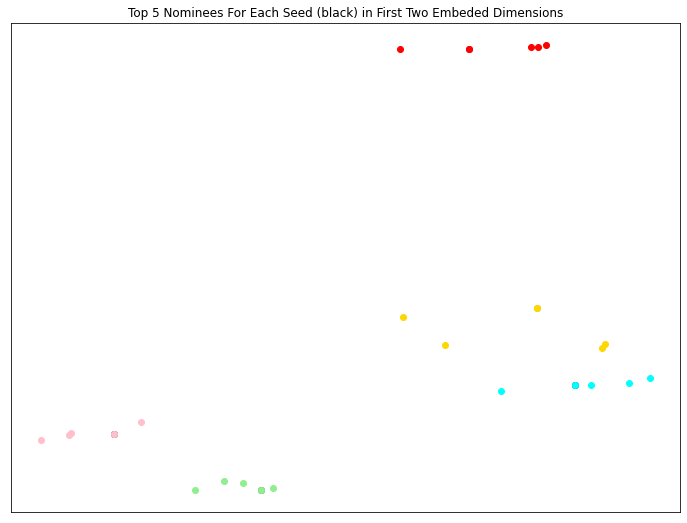

In [7]:
# define the seed as a random sample of 5 vertices from V.
seed = np.random.choice(3 * n_verts, size=5, replace=False).astype(np.int)
nomination_matrix, distance_matrix = svn.predict(seed)

color = ['red', 'lightgreen', 'gold', 'cyan', 'pink']
seed_color = ['firebrick', 'green', 'tan', 'darkblue', 'purple']
plt.figure(figsize=(12, 9))
for i in range(nomination_matrix.shape[1]):
    plt.scatter(svn.embedding_[seed[i], 0],
                svn.embedding_[seed[i], 1],
                c=seed_color[i])
    plt.scatter(svn.embedding_[nomination_matrix[:, i], 0],
                svn.embedding_[nomination_matrix[:, i], 1],
                c=color[i])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Top 5 Nominees For Each Seed (black) in First Two Embeded Dimensions')

The attributed case is not currently handled by Graspologic, and may be added in the future.